# Script to extract SRTM elevations over study sites through Google Earth Engine (GEE)

Adapted from [2022 ICESat Hackweek notebook](https://github.com/ICESAT-2HackWeek/website2022/blob/main/book/tutorials/DataVisualization/Visualization_Earth_Engine_geemap_IS2_HW_2022.ipynb)

To-Do:
- adjust to account for different beams in different ATL files
- use rioxarray to save information for each ICESat-2 track?
- separate elevation difference calculations by study area and/or track (biases could be different)
- plot elevations in map view

In [1]:
import os
import ee
import pandas as pd
import geopandas as gpd
import geemap
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import h5py
from rasterio import plot, warp

In [2]:
# -----GEE Authentication and Initialization
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

### Extract SRTM elevations for AOI #1: Grand Mesa, CO

In [3]:
# -----Create geojson AOI
# used geojson.io
AOI1 = ee.Geometry({"type": "Polygon","coordinates": 
                    [[[-108.24005126953124,38.884619201291905],
                      [-107.9,38.884619201291905],
                      [-107.9,39.11727568585598],
                      [-108.24005126953124,39.11727568585598],
                      [-108.24005126953124,38.884619201291905]]
                    ]})

# -----Query for SRTM, clip to AOI
SRTM1 = ee.Image("USGS/SRTMGL1_003").clip(AOI1)

# -----Plot elevations
# from: https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api
SRTM1_url = SRTM1.getThumbUrl({
    'min': 0, 'max': 6000,
    'palette': ['white', 'green']})
Image(url=SRTM1_url)

### Extract SRTM elevations for AOI #2: Mores Creek Summit, ID

In [4]:
# -----Create geojson AOI
# used geojson.io
AOI2 = ee.Geometry({
        "type": "Polygon",
        "coordinates": [[[-115.74131011962889,43.8855215890078],
                         [-115.61874389648438,43.8855215890078],
                         [-115.61874389648438,43.963661859597536],
                         [-115.74131011962889,43.963661859597536],
                         [-115.74131011962889,43.8855215890078]
                        ]]})

# -----Query for SRTM clip to AOI
SRTM2 = ee.Image("USGS/SRTMGL1_003").clip(AOI2)

# -----Plot elevations
# from: https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api
SRTM2_url = SRTM2.getThumbUrl({
    'min': 0, 'max': 6000,
    'palette': ['white', 'green']})
Image(url=SRTM2_url)

In [5]:
# -----Load snow-off ICESat-2 track
data_path = '/home/jovyan/data/'
is2_file = 'processed_ATL08_20200920013522_13240806_005_01.h5' # Sept = snow-off 

with h5py.File(data_path+is2_file, 'r') as f:
    is2_gt2l = pd.DataFrame(data={'lat': f['gt2l/land_segments/latitude'][:],
                                 'lon': f['gt2l/land_segments/longitude'][:],
                                  'h_te_best_fit': f['gt2l/land_segments/terrain/h_te_best_fit'][:]})

# select one of the beams and convert it to a geodataframe
is2_gdf = gpd.GeoDataFrame(is2_gt2l, geometry=gpd.points_from_xy(is2_gt2l.lon, is2_gt2l.lat), crs='epsg:7661')
is2_gdf.head()


,lat,lon,h_te_best_fit,geometry
0,43.937279,-115.664154,1867.905884,POINT (-115.66415 43.93728)
1,43.936382,-115.664284,1824.602539,POINT (-115.66428 43.93638)
2,43.935486,-115.664406,1801.802979,POINT (-115.66441 43.93549)
3,43.934586,-115.664528,1810.246460,POINT (-115.66453 43.93459)
4,43.933689,-115.664642,1814.206665,POINT (-115.66464 43.93369)


In [6]:
# -----function to convert pandas GeoDataFrame to ee.FeatureCollection
from functools import reduce
def feature2ee(gdf):
    g = [i for i in gdf.geometry]
    features=[]
    #for Point geo data type
    if (gdf.geom_type[0] == 'Point'):
        for i in range(len(g)):
            g = [i for i in gdf.geometry]
            x,y = g[i].coords.xy
            cords = np.dstack((x,y)).tolist()
            double_list = reduce(lambda x,y: x+y, cords)
            single_list = reduce(lambda x,y: x+y, double_list)
            g=ee.Geometry.Point(single_list)
            feature = ee.Feature(g)
            features.append(feature)
        ee_object = ee.FeatureCollection(features)
        return ee_object

In [7]:
# -----convert ICESat-2 gdf to ee.FeatureCollection
is2_ee = feature2ee(is2_gdf)
is2_ee.getInfo();

# -----sample SRTM elevation at ICESat-2 coordinates
SRTM2_sample = ee.FeatureCollection(SRTM2.sample(is2_ee))
SRTM2_sample_gdf = geemap.ee_to_geopandas(SRTM2_sample, selectors=['elevation'])
SRTM2_sample_gdf['lon'] = is2_gdf['lon']
SRTM2_sample_gdf['lat'] = is2_gdf['lat']

# -----calculate elevation difference
snow_off_diff = is2_gdf['h_te_best_fit'] - SRTM2_sample_gdf['elevation']

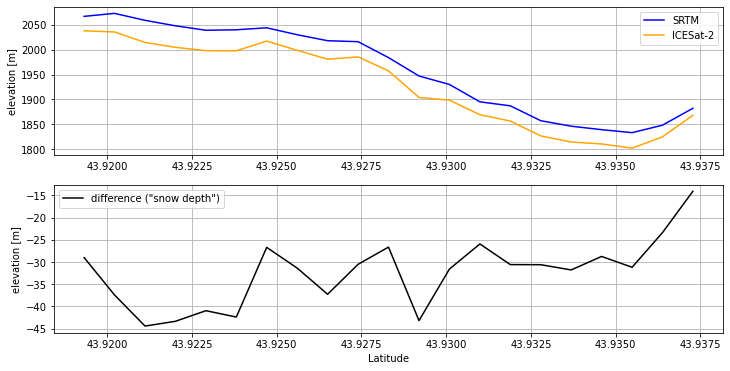

figure saved to file


In [9]:
# -----plot
# SRTM & ICESat-2 elevations
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.plot(SRTM2_sample_gdf['lat'], 
         SRTM2_sample_gdf['elevation'], color='blue', label='SRTM')
ax1.plot(SRTM2_sample_gdf['lat'],
         is2_gdf['h_te_best_fit'], color='orange', label='ICESat-2')
ax1.set_ylabel('elevation [m]')
ax1.grid()
ax1.legend()
# elevation difference
ax2.plot(SRTM2_sample_gdf['lat'], snow_off_diff, color='black', label='difference ("snow depth")')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('elevation [m]')
ax2.legend()
ax2.grid()
plt.show()

# -----save figure
fig.savefig('../figures/snow_free_profile_SRTM_processed_ATL08_20200920013522_13240806_005_01.png',dpi=200)
print('figure saved to file')

KeyError: 'Unable to open object (component not found)'

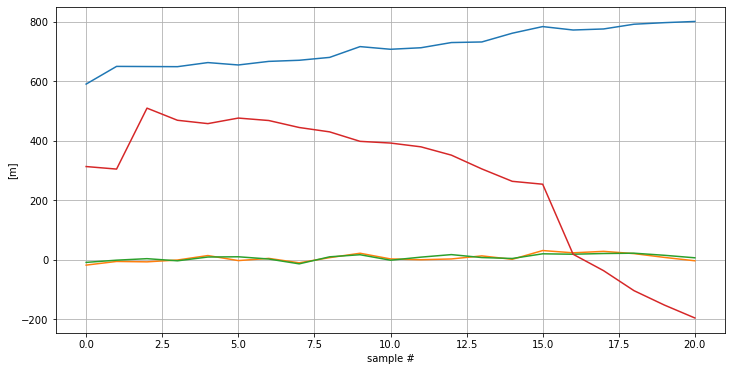

In [12]:
# -----run for other ICESat-2 tracks, using diff to adjust snow depths

# create figure
fig2, axA = plt.subplots(1, 1, figsize=(12, 6))
axA.set_xlabel('sample #')
axA.set_ylabel('[m]')
axA.grid()

# grab ICESat-2 file names
file_names = os.listdir(data_path)
# loop through files
for file_name in file_names:
    
    # load file
    with h5py.File(data_path+file_name, 'r') as f:
        is2_gt2l = pd.DataFrame(data={'lat': f['gt2l/land_segments/latitude'][:],
                                      'lon': f['gt2l/land_segments/longitude'][:],
                                      'h_te_best_fit': f['gt2l/land_segments/terrain/h_te_best_fit'][:]})

    # convert is2 to a geodataframe
    is2_gdf = gpd.GeoDataFrame(is2_gt2l, geometry=gpd.points_from_xy(is2_gt2l.lon, is2_gt2l.lat), crs='epsg:7661')

    # convert is2 gdf to ee.FeatureCollection
    is2_ee = feature2ee(is2_gdf)

    # sample SRTM elevation at ICESat-2 coordinates
    # SRTM1
    SRTM1_sample = ee.FeatureCollection(SRTM1.sample(is2_ee))
    SRTM1_sample_gdf = geemap.ee_to_geopandas(SRTM1_sample, selectors=['elevation'])
    SRTM1_sample_gdf['lon'] = is2_gdf['lon']
    SRTM1_sample_gdf['lat'] = is2_gdf['lat']
    # SRTM2
    SRTM2_sample = ee.FeatureCollection(SRTM2.sample(is2_ee))
    SRTM2_sample_gdf = geemap.ee_to_geopandas(SRTM2_sample, selectors=['elevation'])
    SRTM2_sample_gdf['lon'] = is2_gdf['lon']
    SRTM2_sample_gdf['lat'] = is2_gdf['lat']
    # determine which one applies
    if 'elevation' in SRTM1_sample_gdf.columns:
        SRTM_sample_gdf = SRTM1_sample_gdf
    elif 'elevation' in SRTM2_sample_gdf.columns:
        SRTM_sample_gdf = SRTM2_sample_gdf
    
    # -----calculate elevation difference
    diff = is2_gdf['h_te_best_fit'] - SRTM_sample_gdf['elevation']
    
    # plot "snow depth" (subtracting difference)
    axA.plot(diff - snow_off_diff, label=file_name[17:24])
    
axA.legend()
plt.show()

👆 returns an error! different beams/variables in different files?

In [ ]:
# -----create a map
Map = geemap.Map()
Map.addLayer(AOI1)
Map.addLayer(AOI2)
Map.addLayer(SRTM2, {min:1000, max:3000})
Map.addLayer(SRTM1, {min:1000, max:3000})
Map.addLayer(is2_ee)
Map.centerObject(AOI2, zoom=12)
Map